# Content Wrangling with LangChain
This notebook walks through some common (and hopefully useful) strategies for wrangling your content with LLMs using LangChain.  The three use-cases/tasks we will cover are:

* Summarization
* Classification
* Extraction (Supervised & Un-Supervised)

# Content Source
We'll use the `2024 Q4 Cloudflare Earnings Call Transcript` as our content for this exercise.

In [1]:
import warnings

warnings.filterwarnings('ignore')
import os
from colorama import Fore

with open("content/2024Q4_earnings_call_transcript.txt", "r") as f:
    content_earnings_transcript = f.read()

In [2]:
content_earnings_transcript[:500]

'Operator: Good afternoon. My name is Emma and I will be your conference operator today. At this time, I would like to welcome everyone to the Cloudflare Q4 2021 Earnings Call. [Operator Instructions] Thank you. Jayson Noland, you may begin your conference.\nJayson Noland: Thank you for joining us to discuss Cloudflare’s financial results for the fourth quarter 2021. With me on the call, we have Matthew Prince, Co-Founder and CEO; Michelle Zatlyn, Co-Founder, President and COO; and Thomas Seifert,'

# Setup
We'll use an LLM from Cloudflare's [WorkersAI](https://developers.cloudflare.com/workers-ai/) platform to perform the tasks in this exercise.  If you want to use another provider, visit the [LangChain Integrations](https://python.langchain.com/docs/integrations/providers/) to see what's available.

If you want to use WorkersAI like this demo, you will need the following:
* Cloudflare Account Number
* WorkersAI API Token
* Model from WorkersAI [Models Inventory](https://developers.cloudflare.com/workers-ai/models/)


In [3]:
from dotenv import load_dotenv

load_dotenv(".env")

gateway_id = os.environ["AI_GATEWAY_ID"]
cf_acct_id = os.environ["CF_ACCT_ID"]
model_workersai = "@cf/meta/llama-3.3-70b-instruct-fp8-fast"

In [4]:
from langchain_community.llms.cloudflare_workersai import CloudflareWorkersAI

llm = CloudflareWorkersAI(
    account_id=cf_acct_id,
    api_token=os.environ["WORKERSAI_TOKEN"],
    model=model_workersai
)

# optional if you want to use AI Gateway
llm.endpoint_url = f"https://gateway.ai.cloudflare.com/v1/{cf_acct_id}/{gateway_id}/workers-ai/{model_workersai}"

# 1) Summarization
Summarizing content into smaller, more bite-sized pieces is a valuable feature that LLMs can provide. We'll use the LangChain [load_summarize_chain](https://python.langchain.com/v0.2/api_reference/langchain/chains/langchain.chains.summarize.chain.load_summarize_chain.html) with Map Reduce for this.


In [5]:
from langchain.chains.summarize import load_summarize_chain
from utils.summarization import map_prompt, combine_prompt

chain = \
    load_summarize_chain(
        llm,
        chain_type="map_reduce",
        map_prompt=map_prompt,
        combine_prompt=combine_prompt,
        verbose=False
    )

In [6]:
from langchain_core.documents import Document

doc = Document(page_content=content_earnings_transcript)

In [7]:
%%capture

summary = chain.invoke([doc]);

In [8]:
arr_highlights = \
    [
        x.strip() for x in summary.get("output_text").split(".")
        if x.strip() != ""
    ]

[print(Fore.LIGHTWHITE_EX + f"* {x}\n") for x in arr_highlights];

* Cloudflare's main themes include strong financial performance with 54% year-over-year Q4 revenue growth to $194 million and 52% full-year growth to $656 million

* The company's products, such as Workers and Cloudflare One, are driving growth through strong adoption

* Geographically, all regions showed strong growth, with EMEA being the highest

* The future business outlook involves continued investment in innovation and product expansion to build a better Internet

* Financial guidance expects 48-49% revenue growth in Q1 and 41-42% for the full year 2022



# 2) Classification

Now that we've gotten the high level summaries from our content, we will perform another useful task of "classifying" these outputs into different categories.

In this exercise we want to determine which type of business category these highlights fall into: **(strength, opportunity, milestone, weakness, challenge)**

In [9]:
from utils.classification import classification_prompt_template, Data, Note, cls_color_mapping
from utils.extraction import parse_output, build_structured_results

In [10]:
print(Fore.CYAN + f"Running {len(arr_highlights)} Classifications")

arr_results = []
arr_not_matched = []

# Get structured response outputs
for idx, text in enumerate(arr_highlights):
    prompt = classification_prompt_template.format(text=text)
    response = llm.invoke(prompt)
    extracted_data = parse_output(output=response, schema=Data)
    build_structured_results(
        text=text,
        extracted_data=extracted_data,
        arr_results=arr_results,
        arr_not_matched=arr_not_matched,
        schema=Note,
    )

Running 5 Classifications


In [11]:
#Print Highlights with Classifications

for res in arr_results:
    if len(res.results) == 0:
        continue
    print(
        cls_color_mapping(res.results[0].classification) +
        f"* ({res.results[0].classification.upper()}) " +
        Fore.LIGHTWHITE_EX + res.results[0].text
    )
    print("\n")

* (STRENGTH) Cloudflare's main themes include strong financial performance with 54% year-over-year Q4 revenue growth to $194 million and 52% full-year growth to $656 million


* (STRENGTH) The company's products, such as Workers and Cloudflare One, are driving growth through strong adoption


* (STRENGTH) Geographically, all regions showed strong growth, with EMEA being the highest


* (OPPORTUNITY) The future business outlook involves continued investment in innovation and product expansion to build a better Internet


* (OPPORTUNITY) Financial guidance expects 48-49% revenue growth in Q1 and 41-42% for the full year 2022




# 3) Extraction
Another common use-case for LLMs and content is **extraction** of certain peices of information.

There are times when we know what we want to extract, I'll refer to these instances as "supervised".

There are other times when we don't know exactly what we want and so we can lean on the LLM to get useful information for us.  I'll refer to this as "unsupervised"

## Supervised Extraction

Let's examine the use case of searching for specific "statistics" within the content.  A "statistic" or "stat" could be any juicy nugget of information that we might want to know but would otherwise have to hunt for if we read the entire piece of content.

For sake of simplicity we will consider any sentence that mentions a numerical, statistic, percentage or other quantitative "fact" as a "stat".

We will first split the content into sentences and filter for those that contain references to numbers or figures.  **Note:** Many of these are not real "stats" and so the LLM will have to make that judgement for us.




In [12]:
from utils.extraction import get_statistic, split_sentences

sentences = split_sentences(content_earnings_transcript)
sentences_stats = [get_statistic(x) for x in sentences]
sentences_stats = [x for x in sentences_stats if x is not None]

In [13]:
print("\n\n* ".join(sentences_stats[:10]))

At this time, I would like to welcome everyone to the Cloudflare Q4 2021 Earnings Call. [Operator Instructions] Thank you

* Jayson Noland: Thank you for joining us to discuss Cloudflare’s financial results for the fourth quarter 2021

* These statements and other comments are not guarantees of future performance, but rather are subject to risks and uncertainties, some of which are beyond our control including, but not limited to: the extent and duration of the impact of the COVID-19 pandemic and adverse conditions in the general domestic and global economic markets

* All current and prior period financials discussed are reflected under ASC 606

* We would also like to inform you that we will be participating in the JMP Securities Technology Conference on March 7, the KeyBanc Emerging Technology Summit on March 8, and the Morgan Stanley Technology, Media and Telecom Conference on March 9

* In Q4, we achieved revenue of $194 million, up 54% year-over-year

* We added 156 new large cus

Since we are dealing with a lot of potential stats, we will chunk these sentences up so we can run inference on them in batches.

In [14]:
import numpy as np

chunks = np.array_split(sentences_stats, len(sentences_stats) // 25)

In [15]:
import asyncio
from utils.extraction import extraction_prompt_template, parse_output, split_sentences

async def llm_async(prompt: str):
    return await llm.ainvoke(prompt)

responses = []
for idx, chunk in enumerate(chunks):
    print(f"Processing chunk {idx} of {len(chunks)} for size {len(chunk)} requests")
    async_invokes = []

    for sentence in chunk.tolist():
        prompt = extraction_prompt_template.format(text=sentence)
        async_invokes.append(llm_async(prompt))

    async_responses = await asyncio.gather(*async_invokes)
    responses += async_responses

Processing chunk 0 of 13 for size 11 requests
Processing chunk 1 of 13 for size 11 requests
Processing chunk 2 of 13 for size 11 requests
Processing chunk 3 of 13 for size 11 requests
Processing chunk 4 of 13 for size 11 requests
Processing chunk 5 of 13 for size 11 requests
Processing chunk 6 of 13 for size 11 requests
Processing chunk 7 of 13 for size 11 requests
Processing chunk 8 of 13 for size 10 requests
Processing chunk 9 of 13 for size 10 requests
Processing chunk 10 of 13 for size 10 requests
Processing chunk 11 of 13 for size 10 requests
Processing chunk 12 of 13 for size 10 requests


In [16]:
# Get structured response outputs
from utils.extraction import Stats, Stat

arr_results = []
arr_not_matched = []

for text, response in zip(sentences_stats, responses):
    extracted_data = parse_output(output=response, schema=Stats)
    build_structured_results(
        text=text,
        extracted_data=extracted_data,
        arr_results=arr_results,
        arr_not_matched=arr_not_matched,
        schema=Stat,
    )

Inference string could not be matched...
Inference string could not be matched...


In [17]:
import pandas as pd

matched_stats = [x.dict().get("results")[0] for x in arr_results if x.results[0].classification == "stat"]
df_matched_stats = pd.DataFrame.from_records(matched_stats)

print(f"{len(matched_stats)} 'stats' kept out of {len(sentences_stats)}")

88 'stats' kept out of 138


In [18]:
df_matched_stats.sample(frac=0.25)

,text,note,classification
68,We expect operating income for the full year i...,"$10 million to $14 million, $0.03 to $0.04, 35...",stat
80,"So, the new guidance is 12% to 14%, it’s a sli...",12% to 14%,stat
74,"And so we were able to, after the Log4j vulner...",millions and millions of sites,stat
5,While talk across the industry is about increa...,gross margin of 79%,stat
50,Research and development expenses were $37 mil...,$37 million,stat
73,And it was actually a company that we acquired...,two quarters,stat
29,EMEA represented 27% of revenue and increased ...,"27% of revenue, increased 60% year-over-year",stat
0,"In Q4, we achieved revenue of $194 million, up...","revenue of $194 million, up 54%",stat
52,General and administrative expenses were $28 m...,$28 million,stat
32,"We ended the year with 1,416 large customers, ...","1,416 large customers, increase of 71% year-ov...",stat


## Unsupervised Extraction
When we don't know exactly what we want to extract **Knowledge Triples** are an excellent way to get specific, meaningful information out of our content.

### What are Knowledge Triples
A knowledge triple is a simple, three-part statement that captures a fact:

* Subject (what you’re talking about)
* Predicate (how you describe it)
* Object (the thing or quality it relates to)

Examples:
* Paris (subject) is the capital of (predicate) France (object).
* Apple Inc. (subject) builds iPhones in (predicate) China (object).
* LangChain (subject) has the product (predicate) LangSmith (object).

These let both humans and computers organize information clearly, discover connections quickly, and build more intelligent applications—such as question-answering systems or recommendation engines.


Let's use a different content source for this.  The company description for Cloudflare.  We will first break the description up into sentences and then run inference on each sentence.

In [19]:
with open("content/company_description.txt", "r") as f:
    content_company_description = f.read()

sentences = split_sentences(content_company_description)
print("\n\n* ".join(sentences))

CloudFlare, Inc. operates as a cloud services provider that delivers a range of services to businesses worldwide

* The company offers an integrated cloud-based security solution to secure a range of combination of platforms, including public cloud, private cloud, on-premise, software-as-a-service applications, and IoT devices

* Its security products comprise cloud firewall, bot management, distributed denial of service, IoT, SSL/TLS, secure origin connection, and rate limiting products

* The company also offers performance solutions, which include content delivery and intelligent routing, as well as content, mobile, and image optimization solutions

* In addition, it provides reliability solutions comprising load balancing, anycast network, virtual backbone, DNS, DNS resolver, online, and virtual waiting room solutions

* Further, the company offers Cloudflare internal infrastructure solutions, including on-ramps, which connect users, devices, or locations to its network; and filter

In [48]:
import asyncio
from langchain_community.graphs.index_creator import GraphIndexCreator
from utils.extraction import agraph_inference

index_creator = GraphIndexCreator(llm=llm)

In [49]:
# build async requests
async_requests = \
    [
        agraph_inference(
            ic=index_creator,
            text=x
        )
        for x in sentences
    ]

# run async requests
inference_results = await asyncio.gather(*async_requests)

In [50]:
# construct the triples dataframe
triples = \
    [
        graph.get_triples()
        for graph
        in inference_results
    ]

df_triples = \
    pd.concat([
        pd.DataFrame(x, columns=["subject", "object", "predicate"])
        for x in triples if len(x) > 0
    ]).reset_index(drop=True)

Now that we can inspect our Knowledge Triples to get a quick understanding of what Cloudflare does as a company.  We can also use these as the basis for our Knowledge Graph to enhance future retrieval processes.

In [51]:
df_triples[["subject", "predicate", "object"]]

,subject,predicate,object
0,The company,offers,performance solutions
1,performance solutions,include,content delivery
2,performance solutions,include,intelligent routing
3,performance solutions,include,content optimization solutions
4,performance solutions,include,mobile optimization solutions
5,performance solutions,include,image optimization solutions
6,It,provides,reliability solutions
7,reliability solutions,comprise,load balancing
8,reliability solutions,comprise,anycast network
9,reliability solutions,comprise,virtual backbone


Graph has 22 nodes and 20 edges


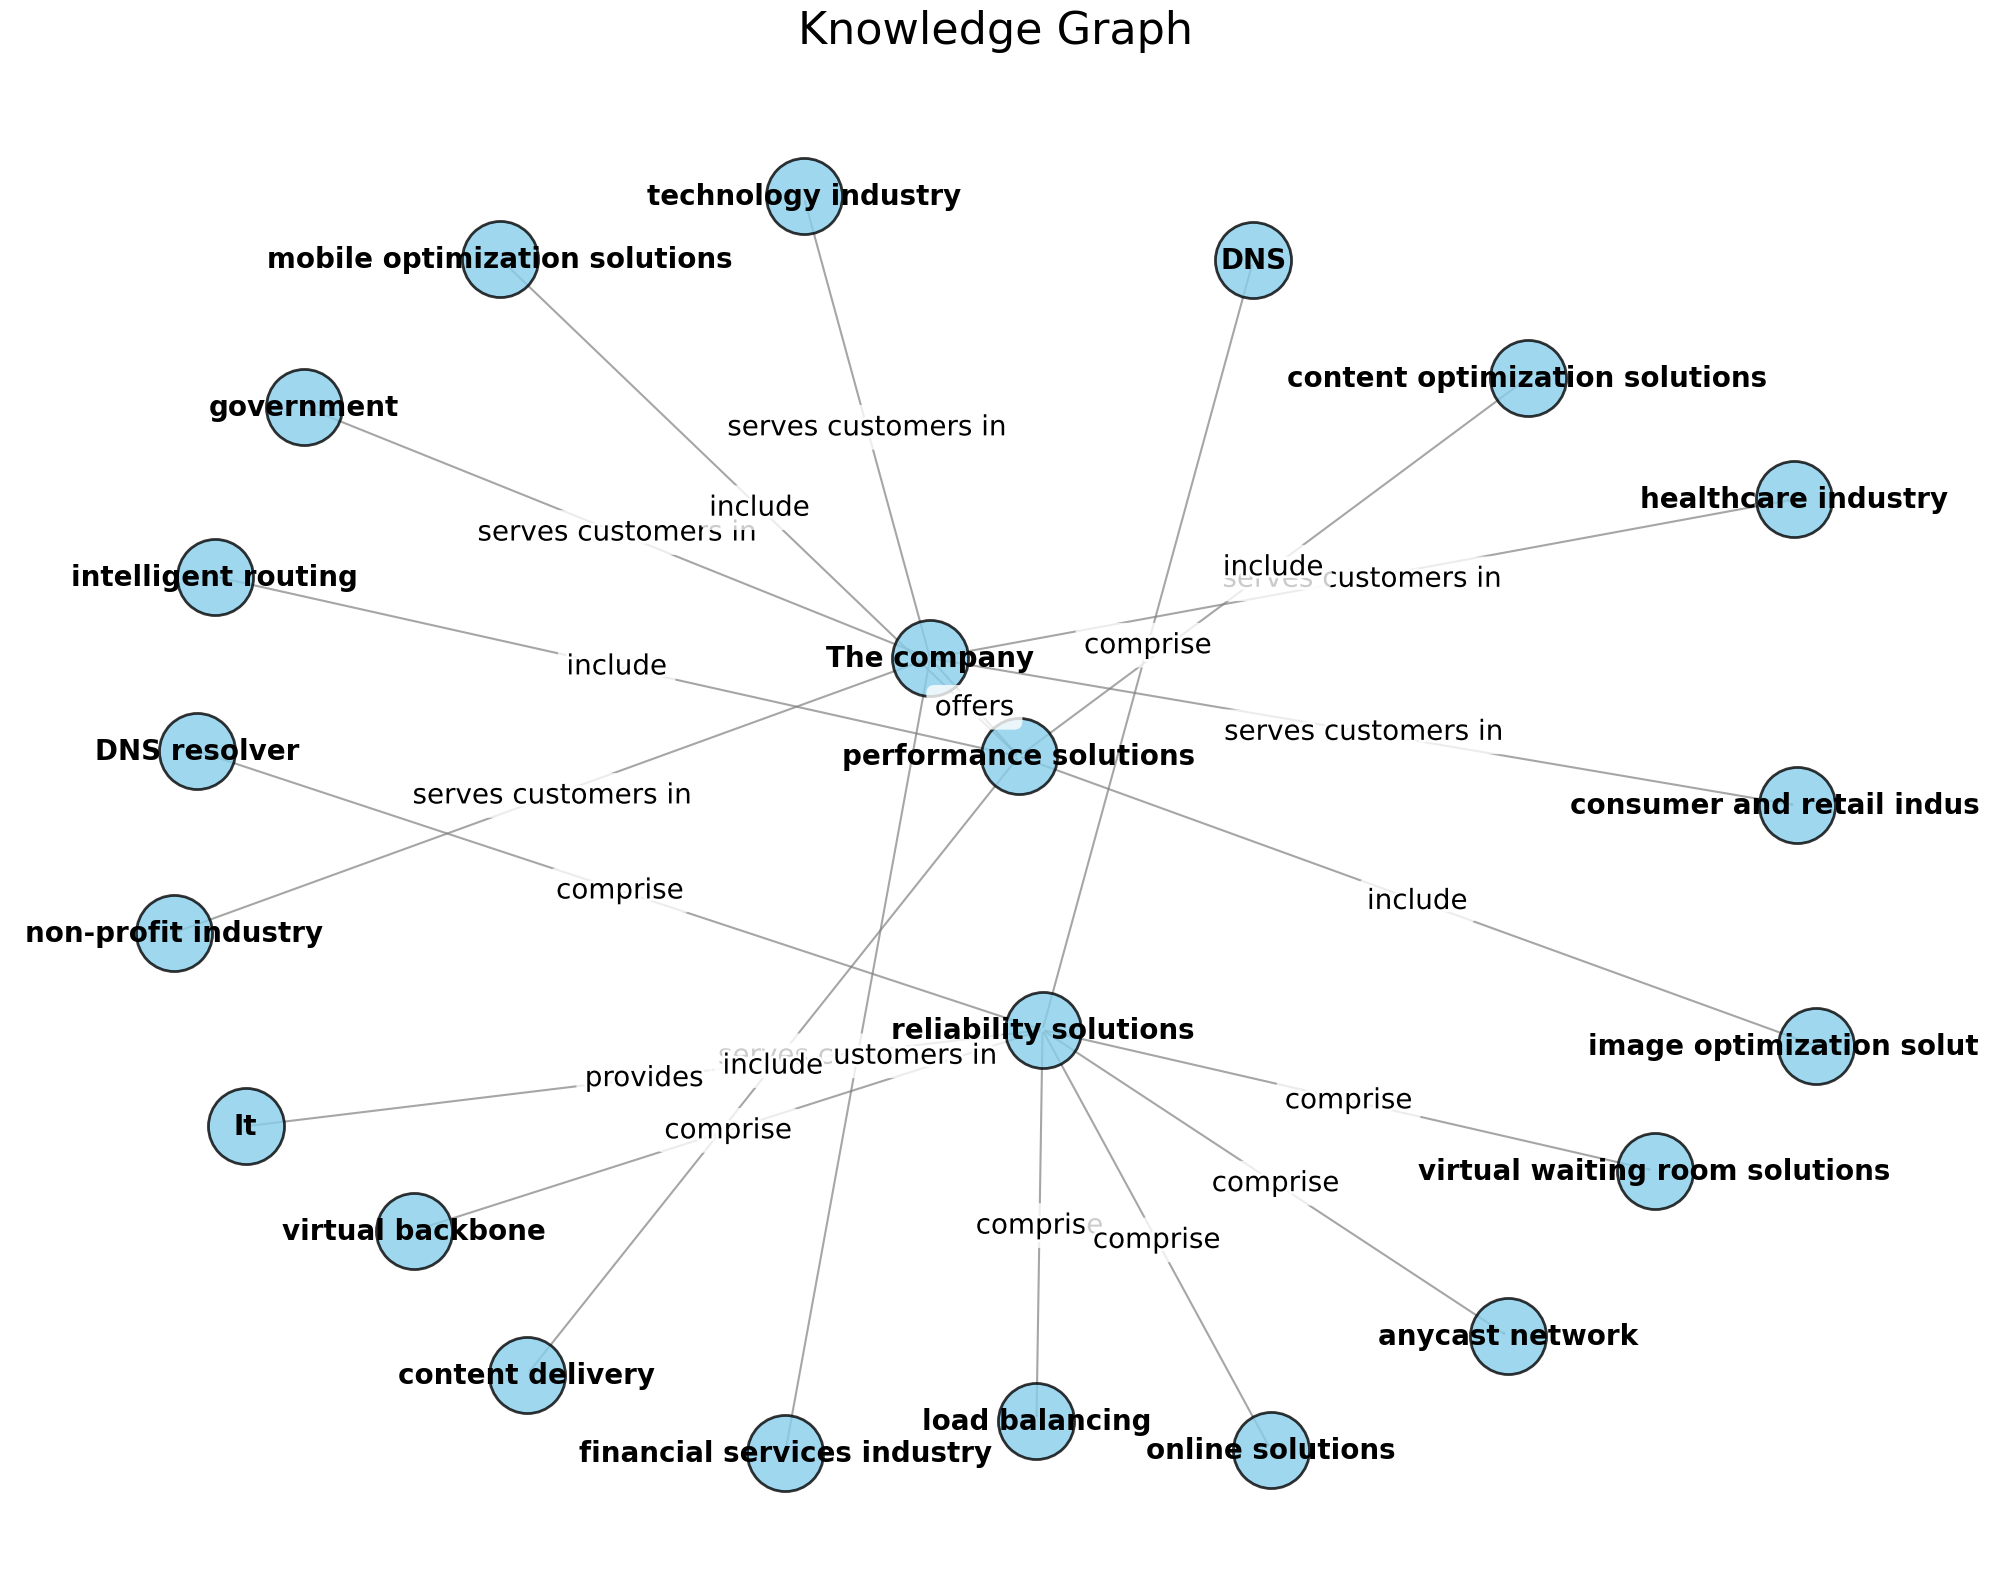

In [52]:
from utils.plots import draw_kt_graph

plt = draw_kt_graph(kt_data=df_triples.to_dict("records"))
plt.show()